In [1]:
# Draw pictures
# - Flattening image
# - logistic regression (one neuron)
# - cross entropy loss


# Python is not an ideal langauge for this
# Jupyter is not an ideal environment for htis
# They are the best we have

# In this example, I am not going to do fancy imports
# I want you to see the layout of torch and torchvision

In [2]:
import torch
import torchvision

In [3]:
# MNIST : hello world
# EMNIST : extended with letters in addition to digits
# KMNIST : Kuzushiji, Japanese characters
# QMNIST : newer MNIST with better source information

data_path = "../data/"

mnist_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_dataset = torchvision.datasets.MNIST(
    root=data_path, train=True, download=True, transform=mnist_transforms
)

In [4]:
# batch_size, shuffle
train_loader = torch.utils.data.DataLoader(train_dataset)

In [5]:
image, label = next(iter(train_loader))

In [6]:
image.shape

torch.Size([1, 1, 28, 28])

In [7]:
label.shape, label

(torch.Size([1]), tensor([5]))

In [8]:
import matplotlib.pyplot as plt

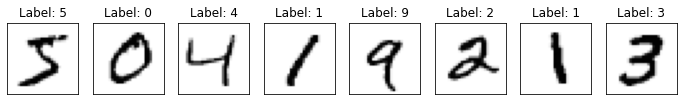

In [9]:
num_to_show = 8

fig, axes = plt.subplots(1, num_to_show, figsize=(12, 12))

for axis, (image, label) in zip(axes, train_loader):
    axis.imshow(image.squeeze(), cmap="Greys")
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axis.set_title(f"Label: {label[0]}")

In [10]:
# Simple single neuron model; sometimes called logistic regression

num_pixels = 28 * 28

# Neuron parameters
weights = torch.randn(num_pixels, 1) * 0.01
bias = torch.zeros(1)

In [11]:
weights.shape, bias.shape, image[0].shape, image[0].view(num_pixels, 1).shape

(torch.Size([784, 1]),
 torch.Size([1]),
 torch.Size([1, 28, 28]),
 torch.Size([784, 1]))

In [12]:
x = image[0]

In [13]:
weights @ x

RuntimeError: mat1 and mat2 shapes cannot be multiplied (28x28 and 1x784)

In [14]:
x = image[0].view(num_pixels, 1)

In [15]:
weights @ x

RuntimeError: mat1 and mat2 shapes cannot be multiplied (784x1 and 784x1)

In [16]:
weights.T @ x

tensor([[-0.4256]])

In [17]:
# from torch import FloatTensor, FloatType

def linear(
    w: torch.FloatTensor, b: torch.FloatType, x: torch.FloatTensor
) -> torch.FloatType:
    return w.T @ x + b

In [18]:
linear(weights, bias, x)

tensor([[-0.4256]])

In [19]:
def sigmoid(z: torch.FloatType) -> torch.FloatType:
    return 1 / (1 + torch.exp(-z))
#     return torch.clamp(z, min=0)

In [20]:
sigmoid(linear(weights, bias, x))

tensor([[0.3952]])

In [21]:
# Get down to two classes (let them pick)
idx1 = [i for i, t in enumerate(train_dataset.targets) if t == 1]
idx2 = [i for i, t in enumerate(train_dataset.targets) if t == 2]

idxs = idx1 + idx2
train_size = len(idxs)

train_loader2 = torch.utils.data.DataLoader(
    train_dataset, sampler=torch.utils.data.SubsetRandomSampler(idxs)
)

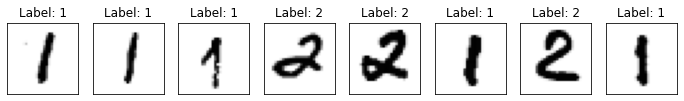

In [22]:
num_to_show = 8

fig, axes = plt.subplots(1, num_to_show, figsize=(12, 12))

for axis, (image, label) in zip(axes, train_loader2):
    axis.imshow(image.squeeze(), cmap="Greys")
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axis.set_title(f"Label: {label[0]}")

In [23]:
from time import time

In [25]:
# Optimization, binary cross-entropy loss (Log loss, aka logistic loss or cross-entropy loss)
# defined as the negative log-likelihood of a logistic model that returns y_pred probabilities for its training data y_true

# compare with: subtraction, MSE, abs

def target_to_sigmoid(target):
    new_target = torch.zeros_like(target)
    new_target[target == 1] = 1
    return new_target

# Neuron parameters
num_pixels = 28 * 28
weights = torch.randn(num_pixels, 1) * 0.01
bias = torch.zeros(1)

num_epochs = 10
learning_rate = 0.01

for epoch in range(num_epochs):

    cost = 0
    weights_derivatives = torch.zeros_like(weights)
    bias_derivative = torch.zeros_like(bias)

    start = time()

    for image, target in train_loader2:

        image = image.view(num_pixels, 1)
        target = target_to_sigmoid(target)

        prediction = sigmoid(linear(weights, bias, image))

        loss = target * torch.log(prediction) + (1 - target) * torch.log(1 - prediction)
        cost -= loss

        dz = prediction - target
        weights_derivatives += image * dz
        bias_derivative += dz.squeeze()

    weights_derivatives /= len(train_loader2)
    bias_derivative /= len(train_loader2)

    weights -= learning_rate * weights_derivatives
    bias -= learning_rate * bias_derivative

    print(
        f"{epoch+1:>2}/{num_epochs}, Cost={cost[0][0]:0.1f}, Time={time()-start:0.1f}s"
    )

 1/10, Cost=8950.1, Time=3.7s
 2/10, Cost=6995.5, Time=3.6s
 3/10, Cost=5772.6, Time=3.7s
 4/10, Cost=4959.3, Time=3.6s
 5/10, Cost=4385.1, Time=3.7s
 6/10, Cost=3959.1, Time=4.0s
 7/10, Cost=3630.1, Time=3.9s
 8/10, Cost=3367.7, Time=3.7s
 9/10, Cost=3153.2, Time=3.6s
10/10, Cost=2974.0, Time=3.7s


In [26]:
train_loader2All = torch.utils.data.DataLoader(
    train_dataset, sampler=torch.utils.data.SubsetRandomSampler(idxs), batch_size=train_size
)

In [27]:
# Vectorize

# Neuron parameters
num_pixels = 28 * 28
weights = torch.randn(num_pixels, 1) * 0.01
bias = torch.zeros(1)

num_epochs = 10
learning_rate = 0.01

for epoch in range(num_epochs):

    weights_derivatives = torch.zeros_like(weights)
    bias_derivative = torch.zeros_like(bias)

    start = time()
    
    images, targets = next(iter(train_loader2All))
#     print(len(images), images.shape, images.view(train_size, num_pixels))

    images = images.view(train_size, num_pixels)
    targets = target_to_sigmoid(targets)
    
    predictions = sigmoid(linear(weights, bias, images.T))
#     print(predictions.shape, targets.shape)

    loss = targets * torch.log(predictions) + (1 - targets) * torch.log(1 - predictions)
    cost = -loss.sum()

    dZ = predictions - targets
    weights_derivatives = (1/train_size) * (dZ @ images)
    bias_derivative = (1/train_size) * dZ.sum()
    
    weights -= learning_rate * weights_derivatives.T
    bias -= learning_rate * bias_derivative
    
    print(
        f"{epoch+1:>2}/{num_epochs}, Cost={cost:0.1f}, Time={time()-start:0.1f}s"
    )

 1/10, Cost=8636.6, Time=1.5s
 2/10, Cost=6813.9, Time=1.5s
 3/10, Cost=5664.2, Time=1.5s
 4/10, Cost=4891.3, Time=1.5s
 5/10, Cost=4340.6, Time=1.5s
 6/10, Cost=3929.1, Time=1.5s
 7/10, Cost=3609.6, Time=1.5s
 8/10, Cost=3353.8, Time=1.5s
 9/10, Cost=3143.9, Time=1.5s
10/10, Cost=2968.1, Time=1.5s


In [28]:
valid_dataset = torchvision.datasets.MNIST(
    root=data_path, train=False, download=True, transform=mnist_transforms
)

# Get down to two classes (let them pick)
idx1 = [i for i, t in enumerate(valid_dataset.targets) if t == 1]
idx2 = [i for i, t in enumerate(valid_dataset.targets) if t == 2]

valid_idxs = idx1 + idx2
valid_size = len(valid_idxs)

print(valid_size)

valid_loader2All = torch.utils.data.DataLoader(
    valid_dataset,
    sampler=torch.utils.data.SubsetRandomSampler(valid_idxs),
    batch_size=valid_size,
)

2167


In [39]:
# Add validation metric

# Neuron parameters
num_pixels = 28 * 28
weights = torch.randn(num_pixels, 1) * 0.01
bias = torch.zeros(1)

num_epochs = 10
learning_rate = 0.01

# Validate with accuracy
valid_images, valid_targets = next(iter(valid_loader2All))
valid_images = valid_images.view(valid_size, num_pixels)
valid_targets = target_to_sigmoid(valid_targets)

valid_predictions = sigmoid(linear(weights, bias, valid_images.T))

accuracy = 1 - (torch.round(valid_predictions) - valid_targets).abs().sum()/valid_size

print(f"Accuracy={accuracy:.2f}")

for epoch in range(num_epochs):

    weights_derivatives = torch.zeros_like(weights)
    bias_derivative = torch.zeros_like(bias)

    start = time()

    images, targets = next(iter(train_loader2All))
    images = images.view(train_size, num_pixels)
    targets = target_to_sigmoid(targets)

    predictions = sigmoid(linear(weights, bias, images.T))

    loss = targets * torch.log(predictions) + (1 - targets) * torch.log(1 - predictions)
    cost = -loss.sum()

    dZ = predictions - targets
    weights_derivatives = (1 / train_size) * (dZ @ images)
    bias_derivative = (1 / train_size) * dZ.sum()

    weights -= learning_rate * weights_derivatives.T
    bias -= learning_rate * bias_derivative

    # Validate with accuracy
    valid_images, valid_targets = next(iter(valid_loader2All))
    valid_images = valid_images.view(valid_size, num_pixels)
    valid_targets = target_to_sigmoid(valid_targets)

    valid_predictions = sigmoid(linear(weights, bias, valid_images.T))

    accuracy = 1 - (torch.round(valid_predictions) - valid_targets).abs().sum()/valid_size
    
    print(
        f"{epoch+1:>2}/{num_epochs}, Cost={cost:0.1f}, Accuracy={accuracy:.2f}, Time={time()-start:0.1f}s"
    )

Accuracy=0.46
 1/10, Cost=9006.4, Accuracy=0.90, Time=1.8s
 2/10, Cost=7047.4, Accuracy=0.93, Time=1.7s
 3/10, Cost=5823.3, Accuracy=0.94, Time=1.8s
 4/10, Cost=5008.8, Accuracy=0.94, Time=1.7s
 5/10, Cost=4433.6, Accuracy=0.94, Time=1.7s
 6/10, Cost=4006.4, Accuracy=0.95, Time=1.7s
 7/10, Cost=3676.2, Accuracy=0.95, Time=1.7s
 8/10, Cost=3412.8, Accuracy=0.95, Time=1.7s
 9/10, Cost=3197.1, Accuracy=0.95, Time=1.7s
10/10, Cost=3016.9, Accuracy=0.95, Time=1.7s


In [30]:
valid_predictions.shape

torch.Size([1, 2167])

In [31]:
valid_targets.shape

torch.Size([2167])

In [32]:
valid_predictions[:10]

tensor([[0.1611, 0.8716, 0.0410,  ..., 0.6587, 0.3552, 0.5439]])

In [33]:
torch.round(valid_predictions)

tensor([[0., 1., 0.,  ..., 1., 0., 1.]])

In [34]:
(torch.round(valid_predictions) - valid_targets).sum()

tensor(56.)

In [35]:
(torch.round(valid_predictions) - valid_targets).sum()/valid_size

tensor(0.0258)

In [36]:
1 - (torch.round(valid_predictions) - valid_targets).sum()/valid_size

tensor(0.9742)

In [37]:
x = 1 - (torch.round(valid_predictions) - valid_targets).sum()/valid_size

In [38]:
f"Accuracy={x:.2f}"

'Accuracy=0.97'